# Project 4 Hackathon

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV
from sklearn import metrics
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
!pwd

/Users/AakashSharma/Documents/DSI/Submissions/Project4


In [3]:
cheap_train = pd.read_csv('./data/cheap_train_sample.csv')
df = pd.DataFrame(cheap_train)

In [4]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
wage              object
dtype: object

In [5]:
# Function for EDA
def eda(dataframe):
    # Replace any blank spaces w/ a underscore.
    dataframe.columns = dataframe.columns.str.replace(" ", "_")
    # Checks for the null values.
    print("missing values: {}".format(dataframe.isnull().sum().sum()))
    #
    print("dataframe index: {}".format(dataframe.index))
    # Checks for data types of the columns within the data frame.
    print("dataframe types: {}".format(dataframe.dtypes))
    # Checks the shape of the data frame.
    print("dataframe shape: {}".format(dataframe.shape))
    # Gives us any statistical information of the data frame.
    print("dataframe describe: {}".format(dataframe.describe()))
    
    # A for loop that does this for every single column & their values within our data frame.
    for item in dataframe:
        print(item)
        print(dataframe[item].nunique())

In [6]:
eda(df)

missing values: 0
dataframe index: RangeIndex(start=0, stop=6513, step=1)
dataframe types: age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
wage              object
dtype: object
dataframe shape: (6513, 14)
dataframe describe:                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  6513.000000  6.513000e+03    6513.000000   6513.000000   6513.000000   
mean     38.529556  1.926640e+05      10.068478   1059.200829     92.108092   
std      13.684351  1.060173e+05       2.589238   7392.040587    413.710886   
min      17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%      27.000000  1.202380e+05       9.000000      0.000000      0.000000   
50%      37.000000  1.8

In [7]:
# All the unique values of the 'wage' column.
# Notice that it's either greater than $50,000 or less than/equal to $50,000
df['wage'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [8]:
df[df.duplicated()].sum()

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
wage              0.0
dtype: float64

In [9]:
object_types = df[['workclass', 
                   'education', 
                   'marital-status',
                   'occupation',
                   'relationship',
                   'sex',
                   'native-country',
                   'wage']]

In [10]:
object_types.head()

,workclass,education,marital-status,occupation,relationship,sex,native-country,wage
0,Private,9th,Divorced,Adm-clerical,Not-in-family,Male,United-States,<=50K
1,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,Male,United-States,<=50K
2,Private,Bachelors,Married-civ-spouse,Sales,Husband,Male,United-States,>50K
3,Private,Bachelors,Married-civ-spouse,Other-service,Husband,Male,United-States,>50K
4,Federal-gov,Masters,Never-married,Exec-managerial,Not-in-family,Female,United-States,>50K


In [11]:
for col in object_types.columns:
    object_types[col] = object_types[col].map(lambda x: x.strip())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
def convert_str_nan(data, columns):
    return df[columns].replace(np.nan, 'None', inplace = True)

def strip_column_names(df, columns):
    df.columns = df.columns.str.strip()
    return df

In [13]:
strip_column_names(df, ['workclass', 'education', 'marital-status',
                   'occupation', 'relationship', 'sex', 'native-country', 'wage'])

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,56,Private,346033,9th,5,Divorced,Adm-clerical,Not-in-family,Male,0,0,40,United-States,<=50K
1,28,Private,96226,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Male,0,0,45,United-States,<=50K
2,33,Private,251120,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,7688,0,50,United-States,>50K
3,26,Private,178140,Bachelors,13,Married-civ-spouse,Other-service,Husband,Male,0,0,45,United-States,>50K
4,40,Federal-gov,56795,Masters,14,Never-married,Exec-managerial,Not-in-family,Female,14084,0,55,United-States,>50K
5,66,Private,284021,HS-grad,9,Widowed,Sales,Not-in-family,Female,0,0,40,United-States,<=50K
6,30,Private,318749,Assoc-voc,11,Married-civ-spouse,Tech-support,Wife,Female,0,0,35,Germany,<=50K
7,43,Private,456236,Masters,14,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,50,United-States,>50K
8,56,Private,244605,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Male,0,0,40,United-States,<=50K
9,29,Private,137063,HS-grad,9,Never-married,Sales,Unmarried,Male,0,0,38,United-States,<=50K


In [14]:
convert_str_nan(df, ['workclass', 'education', 'marital-status',
                   'occupation', 'relationship', 'sex', 'native-country', 'wage'])

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [15]:
# remove question marks
for col in object_types.columns:
    object_types[col] = object_types[col].map(lambda x: x.replace('?', ''))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
object_columns = ['workclass', 
                'education', 
                'marital-status',
                'occupation',
                'relationship',
                'sex',
                'native-country',
                'wage']

for col in object_columns:
    df[col] = df[col].map(lambda x: x.strip())

# remove question marks
for col in object_columns:
    df[col] = df[col].map(lambda x: x.replace('?', ''))

In [17]:
# Function to dummy all the columns within a data frame.
def dummies(df, column):
    column_dummies = pd.get_dummies(df[column], drop_first = True)
    df = df.join(column_dummies)
    return df

df = dummies(df, ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
                   'sex', 'native-country', 'wage'])

In [18]:
df.head().T

,0,1,2,3,4
age,56,28,33,26,40
workclass,Private,Private,Private,Private,Federal-gov
fnlwgt,346033,96226,251120,178140,56795
education,9th,HS-grad,Bachelors,Bachelors,Masters
education-num,5,9,13,13,14
marital-status,Divorced,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Never-married
occupation,Adm-clerical,Craft-repair,Sales,Other-service,Exec-managerial
relationship,Not-in-family,Husband,Husband,Husband,Not-in-family
sex,Male,Male,Male,Male,Female
capital-gain,0,0,7688,0,14084


In [19]:
largest_neg_corr_list = df.corr()[['wage_>50K']].sort_values('wage_>50K').head(5).T.columns
largest_neg_corr_list

Index(['marital-status_Never-married', 'relationship_Own-child',
       'relationship_Not-in-family', 'occupation_Other-service',
       'relationship_Unmarried'],
      dtype='object')

In [20]:
largest_pos_corr_list = df.corr()[['wage_>50K']].sort_values('wage_>50K').tail(5).T.columns.drop('wage_>50K')
largest_pos_corr_list

Index(['age', 'hours-per-week', 'education-num',
       'marital-status_Married-civ-spouse'],
      dtype='object')

In [21]:
X = df[['marital-status_Never-married', 'relationship_Own-child',
      'relationship_Not-in-family', 'occupation_Other-service',
      'relationship_Unmarried', 'occupation_Adm-clerical',
      'occupation_Handlers-cleaners', 'relationship_Other-relative',
      'workclass_Private', 'marital-status_Separated', 'capital-loss',
      'occupation_Prof-specialty', 'occupation_Exec-managerial', 'sex_Male',
      'capital-gain', 'hours-per-week', 'age', 'education-num', 'workclass_Self-emp-inc',
      'marital-status_Married-civ-spouse']]
y = df['wage_>50K']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [23]:
params = {'min_samples_split':[12, 25, 40]}

In [24]:
rf = RandomForestClassifier(n_estimators = 10)

In [25]:
mnb = MultinomialNB()

In [26]:
X.shape

(6513, 20)

In [27]:
y.shape

(6513,)

In [28]:
X_train.shape

(4559, 20)

In [29]:
y_train.shape

(4559,)

In [30]:
X = X.transpose()

In [31]:
mnb_grid = {}
gs_mnb = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
gs_mnb.fit(X_train, y_train)
gs_mnb.score(X_train, y_train)

0.7808729984645756

In [32]:
gs_mnb.score(X_test, y_test)

0.7835209825997953

In [33]:
gs_rf = GridSearchCV(rf, param_grid = params, return_train_score = True, cv = 5)
gs_rf.fit(X_train, y_train)
gs_rf.score(X_train, y_train)

0.8760693134459311

In [34]:
gs_rf.score(X_test, y_test)

0.8607983623336745

In [35]:
gs_rf.best_estimator_.feature_importances_

array([0.04781585, 0.0172763 , 0.03257926, 0.00687536, 0.02318792,
       0.00668721, 0.00393854, 0.00178009, 0.0056051 , 0.00138272,
       0.03400657, 0.02081091, 0.04958508, 0.01068255, 0.18148501,
       0.07325987, 0.09615425, 0.15170815, 0.01335793, 0.22182136])

In [36]:
feat_importance = pd.DataFrame(gs_rf.best_estimator_.feature_importances_, X_test.columns, columns = ['importance'])

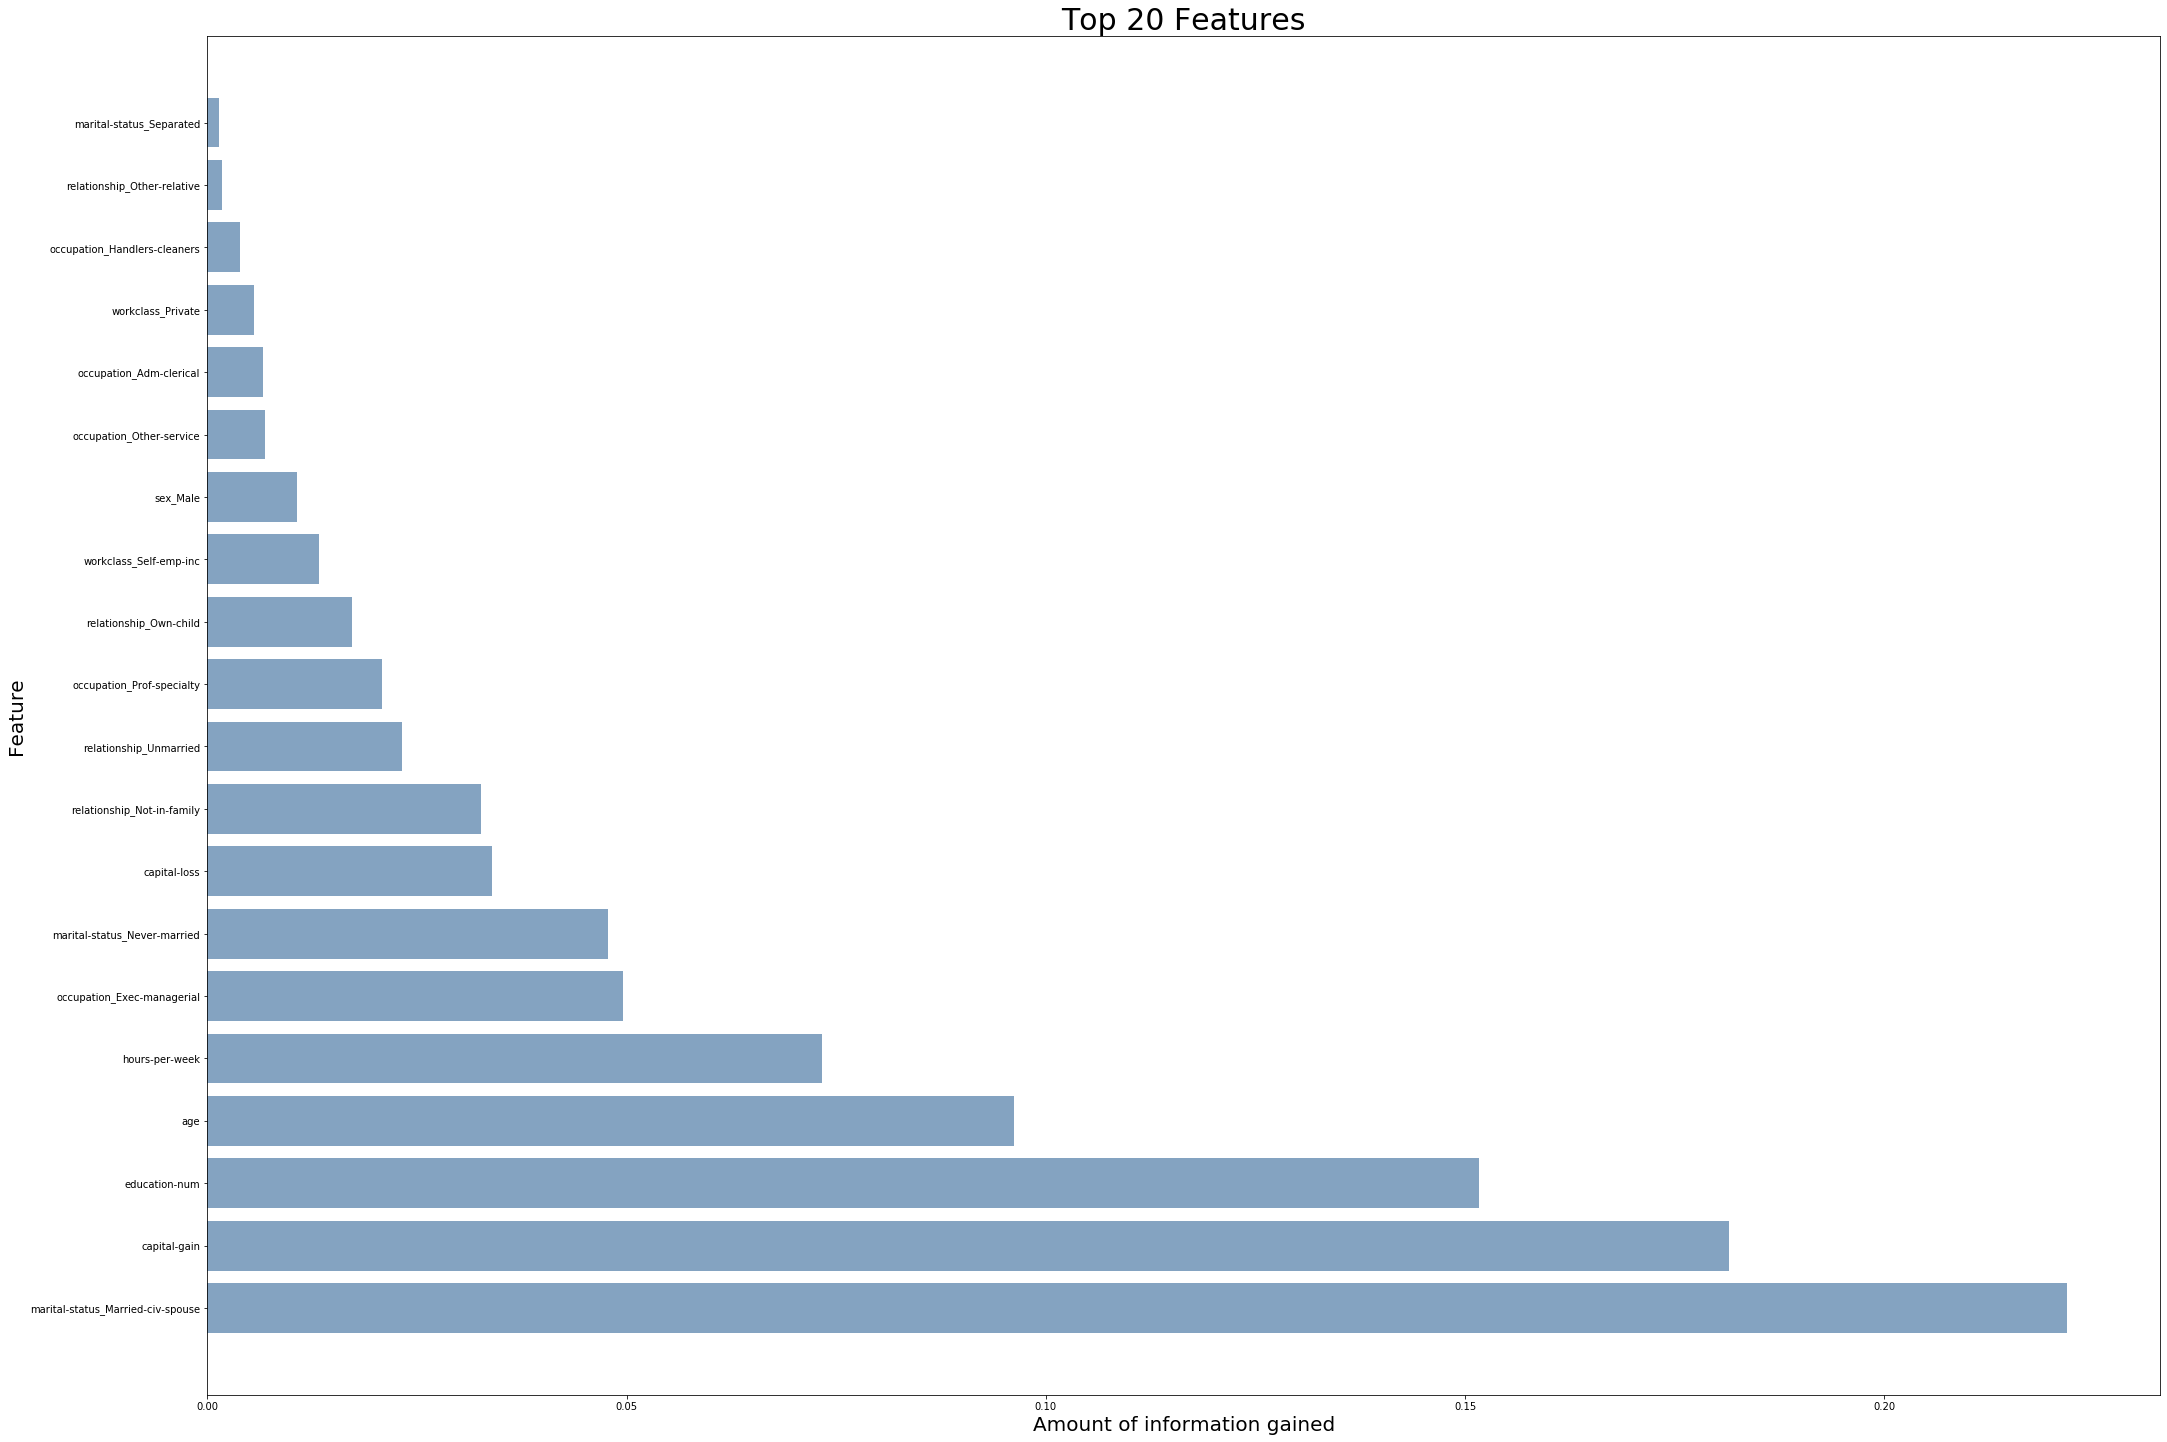

In [47]:
plt.figure(figsize = (35,25))
temp = feat_importance.sort_values('importance', ascending = False).head(20)
plt.barh(temp.index, temp['importance'], color = (0.2, 0.4, 0.6, 0.6))
plt.title('Top 20 Features', fontsize = 30)
plt.xlabel('Amount of information gained', fontsize = 20)
plt.ylabel('Feature', fontsize = 20);

Text(0, 0.5, 'Mean Accuracy')

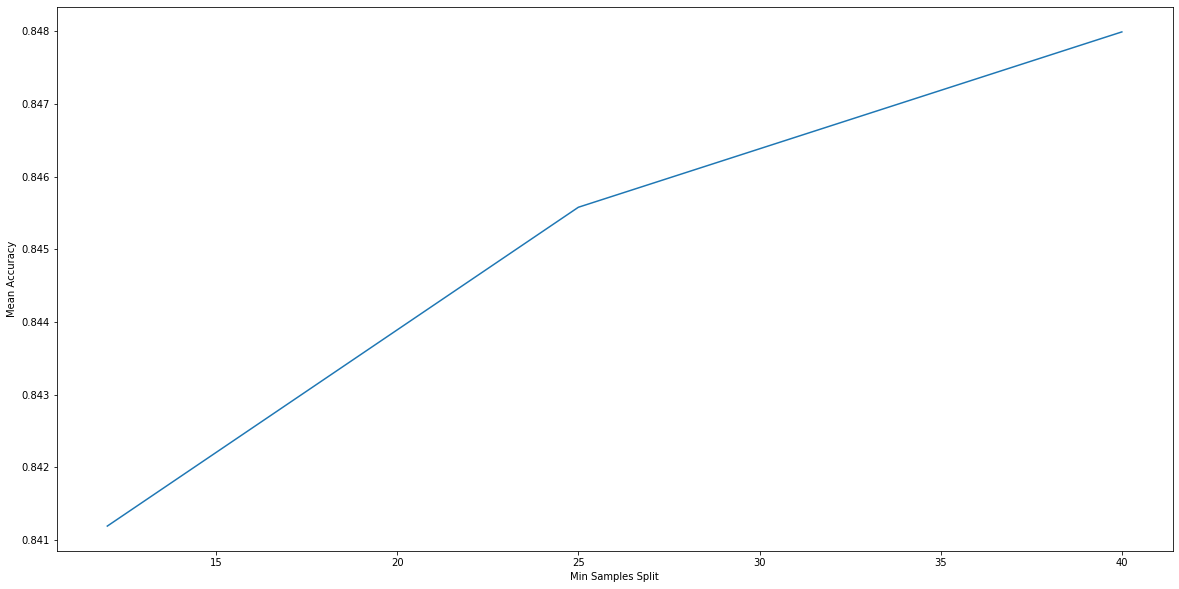

In [55]:
# The visual of our mean accuracy of our feature parameters on the data set.
plt.figure(figsize=(20,10))
plt.plot([param['min_samples_split'] for param in gs_rf.cv_results_['params']],
         gs_rf.cv_results_['mean_test_score'])
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Accuracy')

<Figure size 1800x720 with 0 Axes>

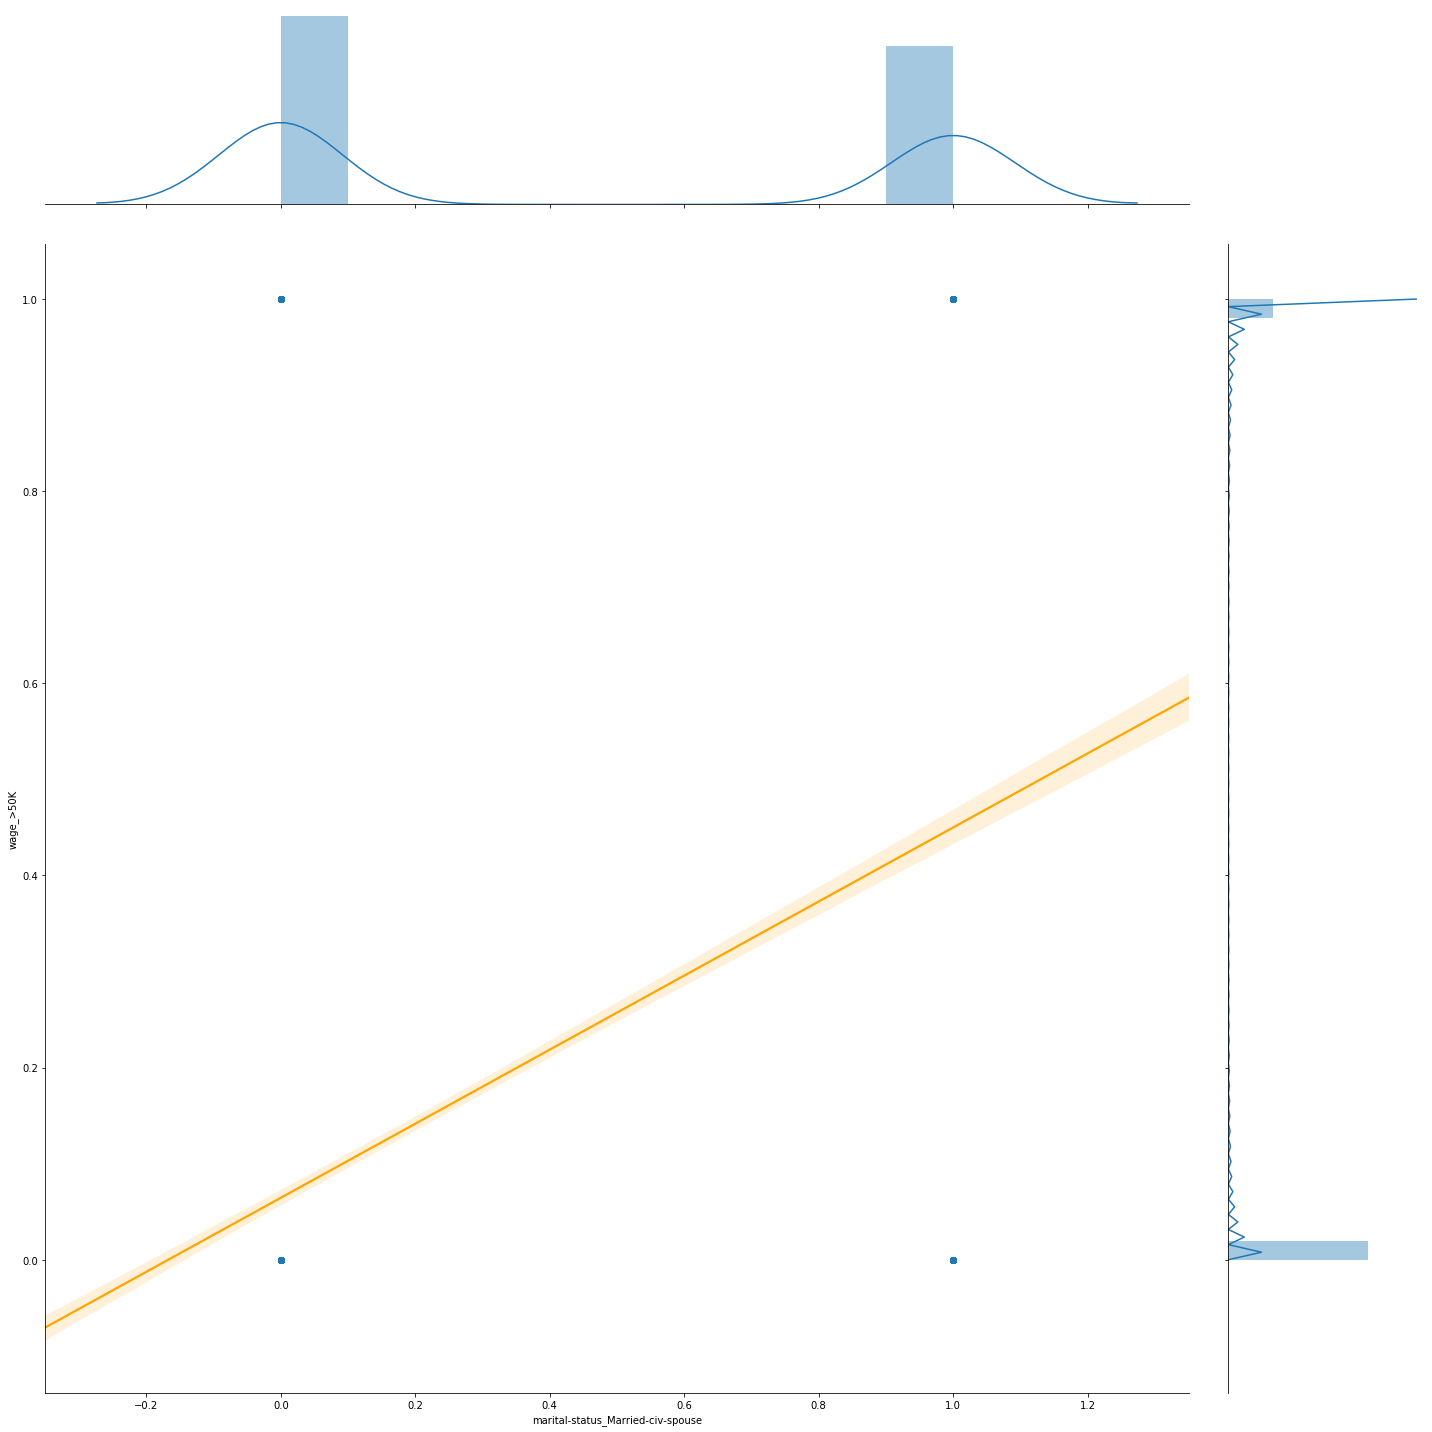

In [59]:
plt.figure(figsize = (25, 10))
sns.jointplot(x = "marital-status_Married-civ-spouse", y = "wage_>50K", data = df, kind = "reg", height = 20, line_kws = {'color': 'orange'});

In [38]:
# df.head().head(2)

In [39]:
# df.shape

In [40]:
# df_numerics_only = df.select_dtypes(include = [np.number])
# df_numerics_only.head(1)

In [41]:
# for col in df.select_dtypes(df_numerics_only != ''):
#     df[col] = df[col].map(lambda x: x.strip())

In [42]:
# for col in df:
#     df[col] = df[col].map(lambda x: x.replace('?', ''))